In [83]:
import networkx as nx
import pandas as pd

# reading in all the data
data = pd.read_csv('DG-AssocMiner_miner-disease-gene-edited.tsv', sep='\t')
dg_edgedata = list(zip(data['# Disease ID'], data['Gene_Name']))            # edge list
disease_nodes = list(set(data['# Disease ID']))                             # disease node list
gene_nodes = list(data['Gene_Name'])                                        # gene node list



Reducing the search space using the data from the Gene-Function network.      
This can be used to remove all the ubiquitous genes as their deletions are more likely to be fatal as compared to the other genes.       
(which also means that they cannot become diseases)
This threshold is debatable, currently set to 0.0005      


In [56]:
# pruning the gene search space

gene_function_data = pd.read_csv('GF-Miner_miner-gene-function.tsv', sep = '\t')
gf_edgedata = list(zip(gene_function_data['# GO_ID'], gene_function_data['Gene']))
gf_graph = nx.Graph()
gf_graph.add_edges_from(gf_edgedata)
deg_cents_gf = nx.degree_centrality(gf_graph)
gene_nodes_gf = list(set(gene_function_data['Gene']))

gene_cents = [(i, deg_cents_gf[i]) for i in deg_cents_gf.keys() if i in gene_nodes_gf]
gene_cents = sorted(gene_cents, key=lambda x: x[1], reverse = True)

ignore_thr = 0.0005
ign_genes = [i[0] for i in gene_cents if i[1] > ignore_thr]      # removing all nodes with higher degree centralities

print(ign_genes)

gene_nodes_gf = [i for i in gene_nodes_gf if i not in ign_genes]    

print('before pruning',len(dg_edgedata))
dg_edgedata = [i for i in dg_edgedata if i[1] not in ign_genes]
print('after pruning',len(dg_edgedata))

['NRP1', 'FGF10', 'BMP4', 'LGALS9', 'TLR4', 'CITED2', 'SOD2', 'PARK2', 'DMD', 'TGFB1', 'CD24', 'CTNNB1', 'APOE', 'DLL1', 'FGF2', 'TNF', 'PTPN22', 'PPP1R9B', 'SLC9A3R1', 'AGT', 'WNT5A', 'TSPO', 'MYD88', 'GATA3', 'WNT7A', 'OGT', 'PARK7', 'FSHR', 'TERT', 'NOTCH1', 'GHR', 'CCL21', 'KLF4', 'PPP1R15A', 'SHH', 'MEN1', 'GREM1', 'APOA1', 'EDN1', 'HMGA2', 'SNAI2', 'ACTN3', 'FOXP1', 'SNCA', 'ADA', 'JAK2', 'CRH', 'HMGB1', 'SLC11A2', 'EHD1', 'CYR61', 'BCL2L11', 'LRP6', 'IL4', 'LYN', 'GJA5', 'CCL5', 'MTOR', 'ABCA1', 'ITGB1BP1', 'RAPGEF3', 'IL1B', 'DRD2', 'SHTN1', 'INS', 'GLI3', 'PDE2A', 'DDX3X', 'DVL1', 'AQP9', 'TCF21', 'SLC25A17', 'KDM1A', 'ITGB1', 'BCL2', 'SRF', 'PTPN2', 'AQP1', 'PTGER4', 'SOX9', 'AK9', 'SCN5A', 'EHMT2', 'IRG1', 'DNM1L', 'TLR3', 'PDGFRB', 'PIK3CD', 'NFIB', 'TOR1A', 'TNFSF11', 'CASQ2', 'AXIN1', 'TCAP', 'SLIT2', 'SERPINA5', 'ADRB2', 'CCR7', 'LHX1', 'PCDH15', 'ATM', 'GSN', 'CACNA1G', 'FASN', 'CNOT1', 'BMPR1B', 'CASR', 'HNF1A', 'WNT10B', 'TBX3', 'DKK1', 'SIX3', 'ANXA1', 'WNT1', 'TNFAI

In [57]:
# making the disease gene association network

DG_graph = nx.Graph()
DG_graph.add_edges_from(dg_edgedata)
DG_graph.nodes

NodeView(('C0036095', 'VCAN', 'DAPK1', 'JAG1', 'MARK2', 'EN1', 'FANCA', 'FAT1', 'MLC1', 'RBFOX2', 'ZIM2', 'ASPM', 'GAS2', 'GAS6', 'PCSK1N', 'GUCY1A1', 'IGFBP2', 'ITGB4', 'KRT5', 'KRT15', 'MARCKS', 'IRX4', 'ISYNA1', 'DTL', 'GINS2', 'PDZK1', 'SERPINF1', 'BCL11A', 'STAG3L1', 'MIER2', 'PRKD1', 'SLC24A3', 'PYGB', 'CCND1', 'ST3GAL4', 'SON', 'SOX4', 'SOX11', 'TOP2A', 'EFHD1', 'WNT5B', 'NETO2', 'HOMER3', 'ESPL1', 'CDH1', 'C0033941', 'ADORA2A', 'ACE', 'AKT1', 'ESR1', 'GRM2', 'GSTP1', 'HTR1A', 'HTR6', 'NPY1R', 'OPRM1', 'PHB', 'SLC6A3', 'CAMK2B', 'RGS9', 'PICK1', 'C0043459', 'HSD17B4', 'PEX1', 'PEX6', 'PEX10', 'PEX12', 'PEX13', 'PEX14', 'PEX26', 'PEX19', 'ABCD3', 'PEX2', 'PEX5', 'PEX3', 'PEX11B', 'PEX16', 'C0033860', 'TNIP1', 'CARM1', 'PSORS4', 'TRAF3IP2', 'HCP5', 'TAGAP', 'ZNF816', 'CP', 'CRP', 'PSORS8', 'CSF2', 'IL23R', 'IFNLR1', 'DDX58', 'FUT2', 'GJB2', 'CYP2S1', 'HLA-C', 'HCAR2', 'LCE3B', 'LCE3C', 'IL12B', 'IL13', 'PSORS9', 'LINC01185', 'MKI67', 'NFKBIA', 'NOS2', 'PCNA', 'IL23A', 'ERAP1', 'SE

In [58]:
# function for getting a weighted projection of the disease gene association network. 
# this will give a specific network of disease nodes with edge weights being the number of genes shared between them 

from itertools import combinations
def get_edge_wt_projection(graph, nodes):
    
    nodes = list(set(nodes))
    wt_prj = nx.Graph()
    combs = combinations(nodes, 2)
    prj = nx.bipartite.projected_graph(graph, nodes)
    wt_prj.edges.data('weight', default=1)
    for comb in combs:
        if comb in prj.edges:
            # count how many nodes are common between the neighbourhoods of the two nodes
            n1 = set(list(DG_graph.neighbors(comb[0])))
            n2 = set(list(DG_graph.neighbors(comb[1])))
            intrsct = n1.intersection(n2)
            wt_prj.add_edge(comb[0], comb[1], weight=len(intrsct))     # add weighted edge to the graph 
    
    return wt_prj

disease_projection = get_edge_wt_projection(DG_graph, disease_nodes)

In [60]:
# finding eigenvector centralities of the nodes
disease_ev_cents = (nx.eigenvector_centrality(disease_projection, max_iter=1000)).items()

# finding degree centralities of the nodes 
disease_dg_cents = (nx.degree_centrality(disease_projection)).items()

eigenvector centrality is not really useful as it doesn't take into account the importance of the connections between two nodes. (information regarding edge weights not being used)

Vertex strength is a better parameter. 

vertex strength is defined as degree times the weight of edges incident on the node. 

(reference: https://doi.org/10.1073/pnas.0400087101)


In [85]:
# calculating the vertex strength of the nodes in the graph

adj = (nx.adjacency_matrix(disease_projection)).todense()           # todense() is for making it into an actual matrix
n = len(disease_projection.nodes)
vertex_st = {}
nodes = list(disease_projection.nodes)

for i in nodes:                 
    vertex_st[i] = 0
    for j in nodes:
        # try except block to prevent keyerror from trying to find non-existent edge. 
        try:
            vertex_st[i] += disease_projection[i][j]['weight'] * adj[nodes.index(i)][nodes.index(j)]  
        except KeyError:
            pass

vertex_st = vertex_st.items()
# vertex_st is a variable which has tuples of the format (node_id, vertex_strength)

In [87]:
# combining all the data into a dataframe

combined_data = pd.DataFrame(columns =['disease ID', 'deg_cent','ev_cent', 'vertex_st'])
combined_data['disease ID'] = [i[0] for i in disease_ev_cents]
combined_data['deg_cent'] = [i[1] for i in disease_dg_cents]
combined_data['ev_cent'] = [i[1] for i in disease_ev_cents]
combined_data['vertex_st'] = [i[1] for i in vertex_st]
combined_data.head()

,disease ID,deg_cent,ev_cent,vertex_st
0,C0268363,0.065637,0.009848,90
1,C0009404,0.677606,0.084612,17704
2,C0041948,0.279923,0.043338,442
3,C0009375,0.708494,0.087448,11634
4,C0003504,0.169884,0.024841,232


In [20]:
# product score
combined_data['product'] = combined_data.deg_cent * combined_data.ev_cent

combined_data['ratio'] = combined_data.deg_cent/combined_data.ev_cent
# Think of some other metric that can be used. 

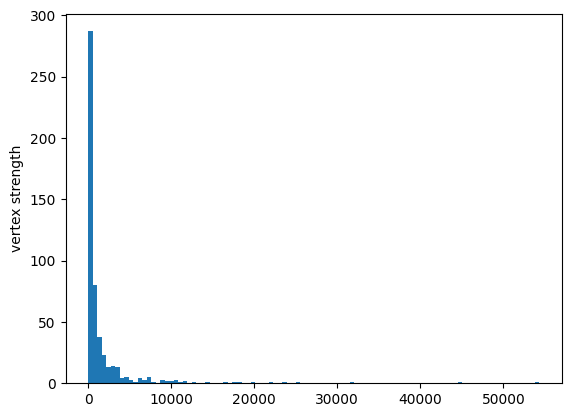

In [91]:
import matplotlib.pyplot as plt
plt.hist(combined_data['vertex_st'], bins = 100)
plt.ylabel('vertex strength')
plt.show()

# proper power law shizz
# this can also be one of the observations we write
# Think of some inferences to be drawn from the disease projection network being a power law network. 
# this also means we might get properly decent clusters (nice.)

TODO: 
1. clustering using Louvain or Girvan Newman method (to get an idea of what are the major diseases and what are the rarer ones)       
2. find overlapping neighbourhoods for pairs of diseases (try doing this using powers of adjacency matrix or local neighbourhood overlap algorithms)     
3. find the weighted projection of the disease gene network on the disease space.      
    - weights are defined as the number of genes connecting the two diseases.      
    - weights will tell how strong the interrelation between the two diseases is.      
    - edges with the highest weights will tell the inverse comorbidity relations.       

In [16]:
# sort the edges according to the weights
sortededges = sorted(disease_projection.edges(data = True), key = lambda x: x[2]['weight'], reverse=True)
top5 = sortededges[:5]
top5

[('C0022336', 'C0027627', {'weight': 1}),
 ('C0022336', 'C0027404', {'weight': 1}),
 ('C0022336', 'C0023467', {'weight': 1}),
 ('C0022336', 'C0027659', {'weight': 1}),
 ('C0022336', 'C0002395', {'weight': 1})]

In [17]:
# find the inverse comorbidity relations
bottom10 = sortededges[-10:]
bottom10

# this has a lot of diseases that are not completely of genetic origin
# we need to filter out those diseases that are purely genetic in origin and the remaining ones will be the ones that are genetically inversely comorbid

[('C0282527', 'C1832200', {'weight': 1}),
 ('C0282527', 'C0043459', {'weight': 1}),
 ('C0282525', 'C1832200', {'weight': 1}),
 ('C0282525', 'C0043459', {'weight': 1}),
 ('C1832200', 'C0043459', {'weight': 1}),
 ('C0032273', 'C0455806', {'weight': 1}),
 ('C0265215', 'C0752166', {'weight': 1}),
 ('C0265215', 'C0403553', {'weight': 1}),
 ('C0752166', 'C0403553', {'weight': 1}),
 ('C1112705', 'C0392557', {'weight': 1})]

In [18]:
sorted_data = pd.DataFrame(sortededges, columns = ['Disease1', 'Disease2', 'Weight'])
sorted_data.loc[sorted_data['Disease1'] == 'C0030567']

,Disease1,Disease2,Weight
32555,C0030567,C0004782,{'weight': 1}
32556,C0030567,C0271650,{'weight': 1}
32557,C0030567,C0001973,{'weight': 1}
32558,C0030567,C0376358,{'weight': 1}
32559,C0030567,C0019829,{'weight': 1}
32560,C0030567,C1961102,{'weight': 1}
32561,C0030567,C0021400,{'weight': 1}
32562,C0030567,C1261502,{'weight': 1}
32563,C0030567,C1168401,{'weight': 1}
32564,C0030567,C0162557,{'weight': 1}
